In [310]:
## PYTHON LIBRARIES
# Importing libraries
import sys
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm, tqdm_notebook
import missingno as msno
import matplotlib.gridspec
from scipy import stats
import matplotlib.patches as mpatches
# Define some general functions
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import datetime
import statsmodels

from skbio.stats.distance import anosim
from scipy.spatial.distance import squareform, pdist
from skbio import DistanceMatrix

import scikit_posthocs as sp
from scipy import stats

## WORKING DIRECTORY
path = "../analysis/plots/"

#run_type = "dry"
run_type = "wet"

#run_user = "Maarouf"
run_user = "Lisonia"

#sex = "f"
sex = "m"


new_day = datetime.datetime.now().strftime("%Y%m%d")

if run_user == "Maarouf":
    palette = {"Continuous": "#808080", "Intermittent" : "#D4D4D4", "Control":"#FFFFFF"}
    markers = {"Continuous": "s", "Intermittent" : "^", "Control":"o"}
elif run_user == "Lisonia":
    palette = {"Control":"#949494", "Intermittent": "#EA8A86", "RapamycinTrametinib":"#EBC69B", "Trametinib":"#7DF17B"}

In [311]:
# Load dataset and metadata
df = pd.read_csv("../data/plasma_normal.csv", sep = ";")
df.set_index("ID", inplace = True)
metadata = pd.read_csv("../metadata/metadata.csv", sep = "\t")
metadata.set_index("ID", inplace = True)

# Subset according to whose study it is
if run_user == "Maarouf":
    metadata = metadata[metadata["Treatment"].isin(["Continuous", "Intermittent", "Control"])]
elif run_user == "Lisonia":
    metadata = metadata[metadata["Treatment"].isin(["Control", "Intermittent", "Trametinib", "RapamycinTrametinib"])]
    
df = df[df.index.isin(metadata.index.to_list())]
mer = pd.merge(df, metadata.loc[:, ["Sex", "Treatment"]], left_index = True, right_index = True)

if sex == "f":
    mer = mer[mer["Sex"] == "f"]
elif sex == "m":
    mer = mer[mer["Sex"] == "m"]
mer.drop(columns = ["Sex"], inplace = True)

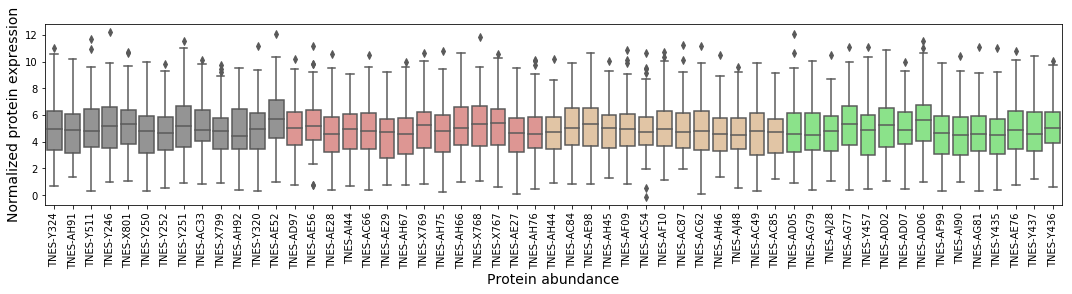

In [312]:
# Plot quality control of protein abundance
sub = mer.sort_values(["Treatment"])
intensities = sub.drop(columns = ["Treatment"]).T
palint = []

for e in sub["Treatment"]:
    palint.append(palette[e])
    
## Average intensities per sample
fig, ax = plt.subplots(figsize = (15, 4))
g = sns.boxplot(data = intensities, ax = ax, palette = palint)
plt.xticks(rotation = 90)
plt.xlabel("Protein abundance")
plt.ylabel("Normalized protein expression")
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
if run_type != "dry":
    plt.savefig(f"{path}/RawQC_protein_abundance_{sex}_{run_user}_{new_day}.pdf")
else:
    plt.show()

In [313]:
def make_pca2(in_df, a, my_pal, wd_dir, sex, run_user, my_markers, top=100):
    b = a + 1
    cols = in_df.columns
    pca = PCA(n_components = 4)
    sorted_mean = in_df.mean(axis = 1).sort_values()
    select = sorted_mean.tail(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_{}'.format(a+1)] = pca.components_[a]
    temp_df['pc_{}'.format(b+1)] = pca.components_[b]
    temp_df.index = cols
    
    print(pca.explained_variance_ratio_)
    temp_df['color'] = my_pal
    
    fig, ax = plt.subplots(figsize = (4,4))
    temp_df.plot(kind = 'scatter', x = 'pc_{}'.format(a+1), y = 'pc_{}'.format(b+1), s = 30, 
                 c = temp_df["color"], ax = ax, edgecolors="black")
    
    ax.set_title("PCA", size = 20)
    ax.set_xlabel("PC{}_{:.3f}%".format(a+1, pca.explained_variance_ratio_[a]*100), size = 18)
    ax.set_ylabel("PC{}_{:.3f}%".format(b+1, pca.explained_variance_ratio_[b]*100), size = 18)
    
    ax.yaxis.label.set_size(18)
    ax.xaxis.label.set_size(18)
    ax.tick_params(axis = "x", labelsize = 12)
    ax.tick_params(axis = "y", labelsize = 12)
    plt.style.context('seaborn-darkgrid')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    # Calculate anosim
    pca_df = temp_df.loc[:, [f"pc_{a+1}", f"pc_{a+2}"]]
    pca_dist = pd.DataFrame(squareform(pdist(pca_df)), columns = pca_df.index, index = pca_df.index)
    pca_dist = DistanceMatrix(pca_dist)
    resanosim = anosim(pca_dist, my_pal, permutations = 999)
    print(f"Anosim test statistic: {resanosim['test statistic']}")
    print(f"Anosim p-value: {resanosim['p-value']}")
    print(f"Anosim Significant?: {resanosim['p-value'] < 0.05}")
    
    if run_type != "dry":    
        plt.savefig("{}/PCA_PCcomp_{}_{}_{}_{}.pdf".format(wd_dir, str(a + 1), sex, run_user, new_day))
    else:
        plt.show()

[0.78374407 0.11073252 0.02130064 0.01831069]
Anosim test statistic: 0.09230823236780865
Anosim p-value: 0.006
Anosim Significant?: True


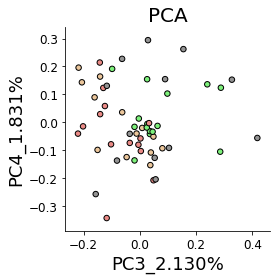

In [322]:
my_pal = []
for e in mer["Treatment"].to_list():
    my_pal.append(palette[e])
    
if run_user == "Maarouf":
    my_markers = []
    for e in mer["Treatment"].to_list():
        my_markers.append(markers[e])
elif run_user == "Lisonia":
    my_markers = "o"
    
make_pca2(mer.drop(columns = ["Treatment"]).fillna(0).T, 2, my_pal, path, sex, run_user, my_markers)

In [315]:
genes = df.columns
if run_user == "Maarouf":
    sig_genes = []
    ctrl_inter = []
    conti_inter = []
    for e in sorted(genes):
        continuous = mer[mer["Treatment"] == "Continuous"].fillna(0)[e]
        intermittent = mer[mer["Treatment"] == "Intermittent"].fillna(0)[e]
        control = mer[mer["Treatment"] == "Control"].fillna(0)[e]
        ano = stats.f_oneway(control, intermittent, continuous)
        if ano[1] < 0.05:
            sig_genes.append(e)
            print(f"\n\n----------{e}----------")
            print("Oneway")
            print(ano)
            ttestdf = pd.DataFrame({"score":list(control) + list(intermittent) + list(continuous), 
                                    "group":["control"]*len(control) + ["intermittent"]*len(intermittent) + ["continuous"]*len(continuous)})
            tte = sp.posthoc_ttest(ttestdf.fillna(0), val_col = "score", group_col = "group")
            print("T-test")
            display(tte)
            comp1 = tte.loc[["intermittent"], ["control"]]["control"][0]
            if comp1 < 0.05:
                ctrl_inter.append(e)
            comp2 = tte.loc[["intermittent"], ["continuous"]]["continuous"][0]
            if comp2 < 0.05:
                conti_inter.append(e)
elif run_user == "Lisonia":
    sig_genes = []
    ctrl_RT = []
    inter_RT = []
    tram_RT = []
    inter_tram = []
    ctrl_inter = []
    ctrl_tram = []
    for e in sorted(genes):
        control = mer[mer["Treatment"] == "Control"].fillna(0)[e]
        inter = mer[mer["Treatment"] == "Intermittent"].fillna(0)[e]
        RT = mer[mer["Treatment"] == "RapamycinTrametinib"].fillna(0)[e]
        tram = mer[mer["Treatment"] == "Trametinib"].fillna(0)[e]
        ano = stats.f_oneway(control, inter, RT, tram)
        if ano[1] < 0.05:
            sig_genes.append(e)
            print(f"\n\n----------{e}----------")
            print("Oneway")
            print(ano)
            ttestdf = pd.DataFrame({"score":list(control) + list(inter) + list(RT) + list(tram), 
                                    "group":["control"]*len(control) + ["intermittent"]*len(inter) + ["RapaTram"]*len(RT) + ["trametinib"]*len(tram)})
            tte = sp.posthoc_ttest(ttestdf.fillna(0), val_col = "score", group_col = "group")
            print("T-test")
            display(tte)
            comp1 = tte.loc[["RapaTram"], ["control"]]["control"][0]
            if comp1 < 0.05:
                ctrl_RT.append(e)
            comp2 = tte.loc[["RapaTram"], ["intermittent"]]["intermittent"][0]
            if comp2 < 0.05:
                inter_RT.append(e)
            comp3 = tte.loc[["RapaTram"], ["trametinib"]]["trametinib"][0]
            if comp3 < 0.05:
                tram_RT.append(e)
            comp4 = tte.loc[["intermittent"], ["trametinib"]]["trametinib"][0]
            if comp4 < 0.05:
                inter_tram.append(e)
            comp5 = tte.loc[["intermittent"], ["control"]]["control"][0]
            if comp5 < 0.05:
                ctrl_inter.append(e)
            comp6 = tte.loc[["trametinib"], ["control"]]["control"][0]
            if comp6 < 0.05:
                ctrl_tram.append(e)



----------Ccl3----------
Oneway
F_onewayResult(statistic=5.757707007745389, pvalue=0.0018018898166945578)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.006972,0.003126,0.486384
intermittent,0.006972,1.000000,0.958614,0.015825
RapaTram,0.003126,0.958614,1.000000,0.007386
trametinib,0.486384,0.015825,0.007386,1.000000




----------Cntn1----------
Oneway
F_onewayResult(statistic=5.3947612593887415, pvalue=0.0026578247808723473)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.002691,0.010015,0.496691
intermittent,0.002691,1.000000,0.870879,0.009289
RapaTram,0.010015,0.870879,1.000000,0.029188
trametinib,0.496691,0.009289,0.029188,1.000000




----------Dll1----------
Oneway
F_onewayResult(statistic=5.413885459098077, pvalue=0.0026036221789546158)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.019571,0.014462,0.863694
intermittent,0.019571,1.000000,0.819507,0.004275
RapaTram,0.014462,0.819507,1.000000,0.002296
trametinib,0.863694,0.004275,0.002296,1.000000




----------Erbb4----------
Oneway
F_onewayResult(statistic=3.245478910885766, pvalue=0.029344017373800664)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.111888,0.687803,0.462209
intermittent,0.111888,1.000000,0.044268,0.001851
RapaTram,0.687803,0.044268,1.000000,0.050504
trametinib,0.462209,0.001851,0.050504,1.000000




----------Fas----------
Oneway
F_onewayResult(statistic=5.636559903768201, pvalue=0.0020503594765232014)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.025873,0.233956,0.153165
intermittent,0.025873,1.000000,0.253400,0.000956
RapaTram,0.233956,0.253400,1.000000,0.014533
trametinib,0.153165,0.000956,0.014533,1.000000




----------Flrt2----------
Oneway
F_onewayResult(statistic=3.16604876712842, pvalue=0.03216432842405838)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.068115,0.103415,0.074072
intermittent,0.068115,1.000000,0.529941,0.642759
RapaTram,0.103415,0.529941,1.000000,0.867407
trametinib,0.074072,0.642759,0.867407,1.000000




----------Gfra1----------
Oneway
F_onewayResult(statistic=5.242512252100891, pvalue=0.0031331406567086926)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.006919,0.078373,0.985661
intermittent,0.006919,1.000000,0.211649,0.001180
RapaTram,0.078373,0.211649,1.000000,0.030026
trametinib,0.985661,0.001180,0.030026,1.000000




----------Hgf----------
Oneway
F_onewayResult(statistic=3.3399501399458704, pvalue=0.02631614624046415)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.417335,0.122555,0.219531
intermittent,0.417335,1.000000,0.492760,0.033488
RapaTram,0.122555,0.492760,1.000000,0.002747
trametinib,0.219531,0.033488,0.002747,1.000000




----------Notch3----------
Oneway
F_onewayResult(statistic=5.090218192713457, pvalue=0.003696887897566735)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.007109,0.026725,0.694300
intermittent,0.007109,1.000000,0.255008,0.005796
RapaTram,0.026725,0.255008,1.000000,0.022853
trametinib,0.694300,0.005796,0.022853,1.000000




----------Plin1----------
Oneway
F_onewayResult(statistic=3.4783089299062637, pvalue=0.022447389154031216)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.092899,0.580779,0.183370
intermittent,0.092899,1.000000,0.282482,0.002089
RapaTram,0.580779,0.282482,1.000000,0.062160
trametinib,0.183370,0.002089,0.062160,1.000000




----------Vsig2----------
Oneway
F_onewayResult(statistic=3.0233204930255413, pvalue=0.03794746634249411)
T-test


,control,intermittent,RapaTram,trametinib
control,1.000000,0.038687,0.926824,0.764581
intermittent,0.038687,1.000000,0.016572,0.004291
RapaTram,0.926824,0.016572,1.000000,0.639588
trametinib,0.764581,0.004291,0.639588,1.000000


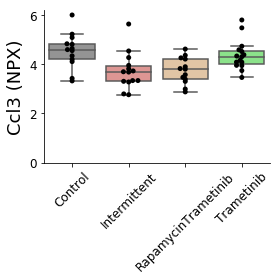

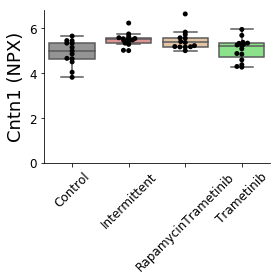

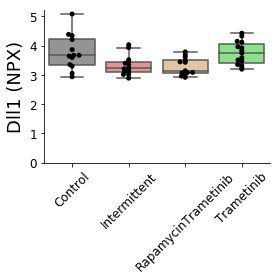

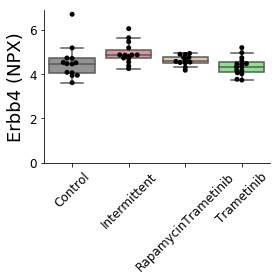

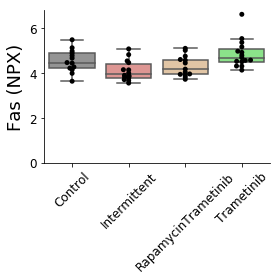

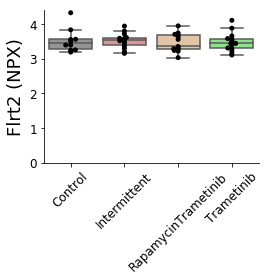

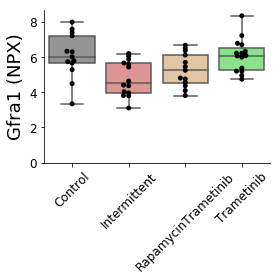

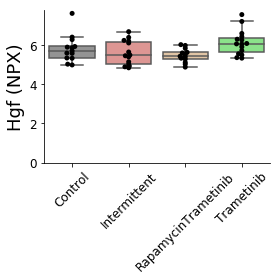

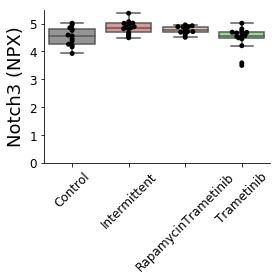

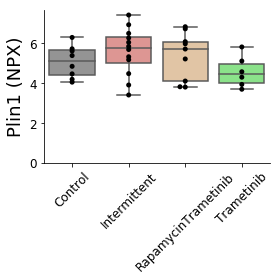

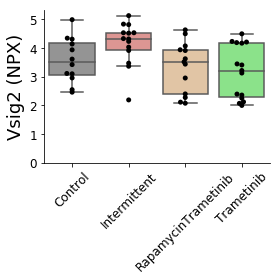

In [316]:
for gene in sig_genes:
    fig, ax = plt.subplots(figsize = (4,4))
    if run_user == "Maarouf":
        sns.boxplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
                order = ["Control", "Intermittent", "Continuous"], palette = palette, fliersize = 0)
        sns.swarmplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
                order = ["Control", "Intermittent", "Continuous"], color = "black")
    elif run_user == "Lisonia":
        sns.boxplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
                order = ["Control", "Intermittent", "RapamycinTrametinib", "Trametinib"], palette = palette, fliersize = 0)
        sns.swarmplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
                order = ["Control", "Intermittent", "RapamycinTrametinib", "Trametinib"], color = "black")
    plt.ylabel(f"{gene} (NPX)")
    ax.yaxis.label.set_size(18)
    plt.ylim(0, None)
    plt.xlabel("")
    ax.tick_params(axis = "x", labelsize = 12, rotation = 45)
    ax.tick_params(axis = "y", labelsize = 12)
    plt.style.context('seaborn-darkgrid')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    if run_type != "dry":
        plt.savefig("{}/SigGene_{}_{}_{}_{}.pdf".format(path, gene, sex, run_user, new_day))
    else:
        plt.show()

In [317]:
# Subset
subs = mer.loc[:, sig_genes + ["Treatment"]]

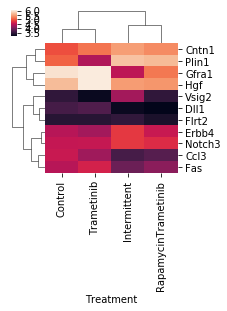

In [326]:
cm = sns.clustermap(subs.groupby("Treatment").median().T, figsize = (3, 3))
matplotlib.rcParams['pdf.fonttype'] = 42
#plt.tight_layout()
    
if run_type != "dry":
    cm.savefig("{}/HeatmapNPXvalues_{}_{}_{}.pdf".format(path, sex, run_user, new_day))
else:
    cm.show()

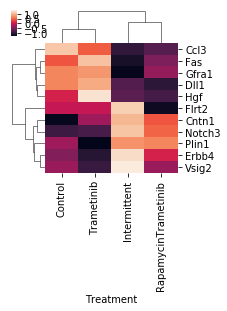

In [327]:
cm = sns.clustermap(subs.groupby("Treatment").median().T, figsize = (3, 3), z_score = 0)
matplotlib.rcParams['pdf.fonttype'] = 42
#plt.tight_layout()
    
if run_type != "dry":
    cm.savefig("{}/HeatmapZscoreGene_{}_{}_{}.pdf".format(path, sex, run_user, new_day))
else:
    cm.show()

In [320]:
if run_user == "Lisonia":
    print(f"Num Significant genes: {len(sig_genes)}")
    print(f"\nNum Control vs RapaTram: {len(ctrl_RT)}")
    for e in ctrl_RT:
        print(e)
    print(f"\nNum Intermittent vs RapaTram: {len(inter_RT)}")
    for e in inter_RT:
        print(e)
    print(f"\nNum Trametinib vs RapaTram: {len(tram_RT)}")
    for e in tram_RT:
        print(e)
    print(f"\nNum Intermittent vs Trametinib: {len(inter_tram)}")
    for e in inter_tram:
        print(e)
    print(f"\nNum Control vs Intermittent: {len(ctrl_inter)}")
    for e in ctrl_inter:
        print(e)
    print(f"\nNum Control vs Trametinib: {len(ctrl_tram)}")
    for e in ctrl_tram:
        print(e)

Num Significant genes: 11

Num Control vs RapaTram: 4
Ccl3
Cntn1
Dll1
Notch3

Num Intermittent vs RapaTram: 2
Erbb4
Vsig2

Num Trametinib vs RapaTram: 7
Ccl3
Cntn1
Dll1
Fas
Gfra1
Hgf
Notch3

Num Intermittent vs Trametinib: 10
Ccl3
Cntn1
Dll1
Erbb4
Fas
Gfra1
Hgf
Notch3
Plin1
Vsig2

Num Control vs Intermittent: 7
Ccl3
Cntn1
Dll1
Fas
Gfra1
Notch3
Vsig2

Num Control vs Trametinib: 0
